In [98]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

In [99]:
data = pd.read_csv('../../Data/cleaned_v2.csv')

In [100]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
val = pd.read_csv('validation.csv')

In [101]:
X_train, Y_train = train["Content_cleaned_v2"], train["Label"]
X_test, Y_test = test["Content_cleaned_v2"], test["Label"]
X_val, Y_val = val["Content_cleaned_v2"], val["Label"]

In [102]:
Y_train = pd.get_dummies(Y_train)
Y_test = pd.get_dummies(Y_test)
Y_val = pd.get_dummies(Y_val)

In [103]:
# from keras_preprocessing.text import Tokenizer
# import pickle
# from keras_preprocessing.sequence import pad_sequences

# tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')

# tokenizer.fit_on_texts(X_train)
# sequences = tokenizer.texts_to_sequences(X_train)
# with open('tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)


In [119]:
from gensim.models import Word2Vec, KeyedVectors
w2v = Word2Vec.load("../../FeatureEngineering/Vectorize/w2vmodel_cbow_256.model")

In [105]:
import pickle
tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))

In [120]:
import numpy as np
notin = []
embedding_dim = 256
maxlen = 350
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
print('num_words:', num_words)
for word, i in word_index.items():
    if word in w2v.wv.key_to_index:
            embedding_matrix[i] = w2v.wv[word]
    else:
        notin.append(word)

num_words: 57132


In [107]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'att': self.att,
            'ffn': self.ffn,
            'layernorm1': self.layernorm1,
            'layernorm2': self.layernorm2,
            'dropout1': self.dropout1,
            'dropout2': self.dropout2,
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    

In [108]:
 # Two seperate embedding layers, one for tokens, one for token index (positions)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim, num_words, embedding_matrix):
        super().__init__()
        self.token_emb = layers.Embedding(num_words, output_dim=embed_dim, input_length=maxlen,weights=embedding_matrix,trainable=False)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'token_emb': self.token_emb,
            'pos_emb': self.pos_emb,
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [121]:
embed_dim = 256  # Embedding size for each token
num_heads = 10    # Number of attention heads
ff_dim = 256    # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen,  embed_dim, num_words, [embedding_matrix])
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(9, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 350)]             0         
                                                                 
 token_and_position_embeddin  (None, 350, 256)         14715392  
 g_8 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_7 (Transf  (None, 350, 256)         2761984   
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_7   (None, 256)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_30 (Dropout)        (None, 256)               0   

In [111]:
from keras_preprocessing import sequence
X_train1 = tokenizer.texts_to_sequences(X_train)
X_train2 = sequence.pad_sequences(X_train1, maxlen)

In [122]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_trans_cbow_256.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

In [113]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [114]:
X_val1 = tokenizer.texts_to_sequences(X_val)
X_val2 = sequence.pad_sequences(X_val1, maxlen)

In [123]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0075), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train2, Y_train, batch_size=64, epochs=30, validation_data=(X_val2, Y_val), callbacks=[early_stopping, checkpoint])

Epoch 1/30
249/249 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.7972
Epoch 1: val_loss improved from inf to 0.44153, saving model to best_trans_cbow_256.h5
249/249 [==============================] - 1160s 5s/step - loss: 0.6407 - accuracy: 0.7972 - val_loss: 0.4415 - val_accuracy: 0.8745
Epoch 2/30
249/249 [==============================] - ETA: 0s - loss: 0.3836 - accuracy: 0.8752
Epoch 2: val_loss improved from 0.44153 to 0.34062, saving model to best_trans_cbow_256.h5
249/249 [==============================] - 1212s 5s/step - loss: 0.3836 - accuracy: 0.8752 - val_loss: 0.3406 - val_accuracy: 0.8885
Epoch 3/30
249/249 [==============================] - ETA: 0s - loss: 0.3440 - accuracy: 0.8879
Epoch 3: val_loss did not improve from 0.34062
249/249 [==============================] - 1148s 5s/step - loss: 0.3440 - accuracy: 0.8879 - val_loss: 0.3424 - val_accuracy: 0.8985
Epoch 4/30
249/249 [==============================] - ETA: 0s - loss: 0.3236 - accuracy:

In [124]:
X_test1 = tokenizer.texts_to_sequences(X_test)
X_test2 = sequence.pad_sequences(X_test1, maxlen)

In [125]:
loss, accuracy = model.evaluate(X_test2, Y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

214/214 [==============================] - 176s 820ms/step - loss: 0.3624 - accuracy: 0.8796
Test Loss: 0.36243507266044617
Test Accuracy: 0.879618763923645


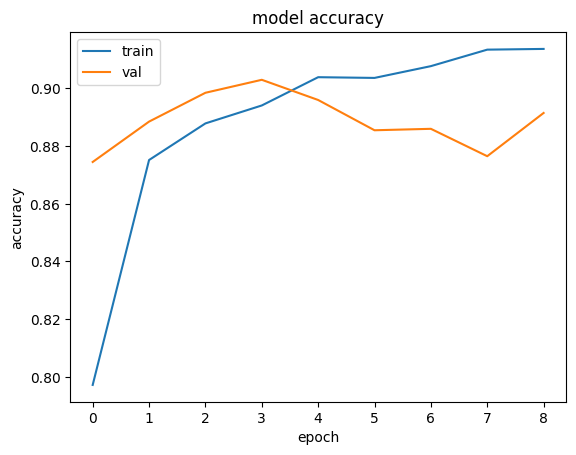

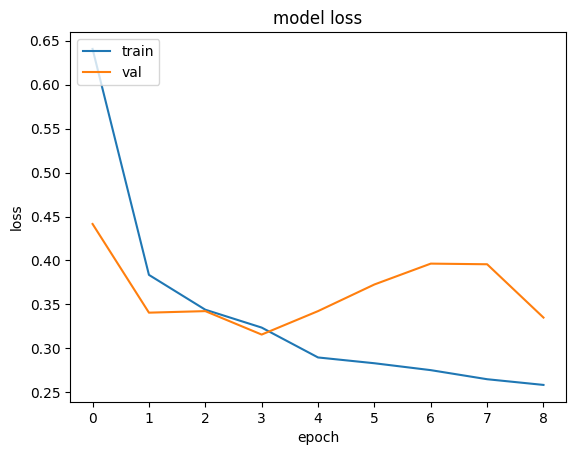

In [126]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()